In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

In [2]:
h = 10
x = y = np.array([h*i for i in range(64)])


In [146]:
das_template_x = np.array([5*np.sqrt(2)*i for i in range(12)])
das_template_y = np.array([5*np.sqrt(2)*i for i in range(12)])
das_template_x2 = np.hstack([das_template_x,das_template_x[::-1],das_template_x,das_template_x[::-1]])
das_template_y2 = np.hstack([das_template_y,das_template_y+das_template_y[-1],das_template_y+2*das_template_y[-1],das_template_y+3*das_template_y[-1]])

das_x = np.hstack([das_template_x2+i*das_template_x[-1] for i in range(4)])
das_y = np.hstack([das_template_y2 for i in range(4)])

offset = (320-np.max(das_x))/2

das_x += offset
das_y += offset

azimuth_template_1 = np.array([[[45 for i in range(12)], [-45 for i in range(12)]] for i in range(2)]).flatten()
azimuth_template_2 = np.array([[[135 for i in range(12)], [215 for i in range(12)]] for i in range(2)]).flatten()
das_az = np.hstack([azimuth_template_1, azimuth_template_2, 
                    azimuth_template_1, azimuth_template_2])

das_azr = np.deg2rad(das_az)

In [4]:
t = np.linspace(0,320,17)
s = np.linspace(0,320,17)

x = y = (t[:-1]+t[1:]) / 2
xst = yst = (s[:-1]+s[1:]) / 2

xs, ys = np.meshgrid(xst,yst)
xs = xs.flatten()
ys = ys.flatten()

# np.random.seed(43771120)
# xs = np.random.uniform(0,320,128)
# ys = np.random.uniform(0,320,128)

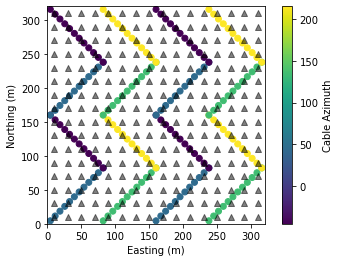

In [5]:
cax = plt.scatter(das_x, das_y,c=das_az)
plt.scatter(xs, ys, marker='^', color='k', alpha=0.5)
plt.xlim(0,320)
plt.ylim(0,320)
plt.colorbar(cax, label="Cable Azimuth")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")

In [6]:
from scipy.io import loadmat
from scipy.interpolate import RectBivariateSpline as rbs
from scipy.integrate import romb
import scipy.sparse as sp
import os

cscale = 2

generate_kernels = True

raz = np.deg2rad(das_az)

L = 10 #gauge length
ll = np.linspace(-L/2, L/2, 2**5+1)
dl = ll[1]-ll[0]
p1 = das_x[:,np.newaxis]+np.sin(raz[:,np.newaxis])*ll[np.newaxis,:]
p2 = das_y[:,np.newaxis]+np.cos(raz[:,np.newaxis])*ll[np.newaxis,:]


if generate_kernels:
    os.makedirs("Kernels", exist_ok=True)
    crv = loadmat("../Curvelet_Basis_Construction/G_16_16.mat")
    G_mat = np.reshape(crv["G_mat"].T, (crv["G_mat"].shape[1], 16, 16))
    crvscales = crv["scales"].flatten()
    cvtscaler = 2.0**(cscale*crvscales)
    G1 = np.zeros((len(raz), G_mat.shape[0]))
    G2 = np.zeros((len(raz), G_mat.shape[0]))
    G3 = np.zeros((len(xs), G_mat.shape[0]))             
    for j in range(G_mat.shape[0]):
        frame = rbs(x,y,G_mat[j])
        #average derivatives of frame along gauge length
        fd1 = romb(frame.ev(p1, p2, dx=1), dl) / L
        fd2 = romb(frame.ev(p1, p2, dy=1), dl) / L
        G1[:,j] = (np.sin(raz)**2*fd1 + 
                  np.sin(2*raz)*fd2/2) / cvtscaler[j]
        G2[:,j] = (np.cos(raz)**2*fd2 + 
                  np.sin(2*raz)*fd1/2) / cvtscaler[j]
        G3[:,j] = frame.ev(xs, ys) / cvtscaler[j]

    np.save("Kernels/G1.npy", G1)
    np.save("Kernels/G2.npy", G2)
    np.save("Kernels/G3.npy", G3)

In [7]:
res = np.load("resmin.npy")

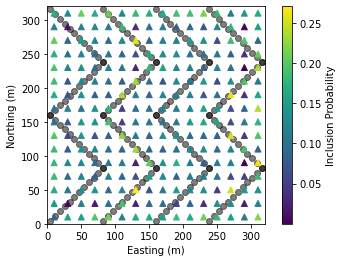

In [8]:
plt.scatter(das_x, das_y, c='k', alpha=0.5)
cax = plt.scatter(xs, ys, c=res, marker='^')
plt.xlim(0,320)
plt.ylim(0,320)
plt.colorbar(cax, label="Inclusion Probability")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")

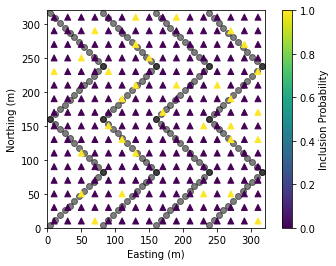

In [9]:
res = np.load("resround.npy")
plt.scatter(das_x, das_y, c='k', alpha=0.5)
cax = plt.scatter(xs, ys, c=res, marker='^')
plt.xlim(0,320)
plt.ylim(0,320)
plt.colorbar(cax, label="Inclusion Probability")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")

In [10]:
np.sum(res)

31.99999999213572

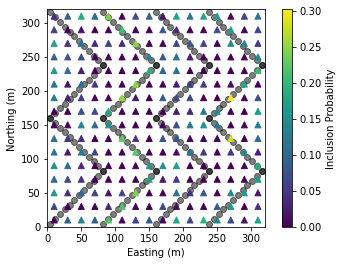

In [11]:
res1 = np.load("res_spectral.npy")
plt.scatter(das_x, das_y, c='k', alpha=0.5)
cax = plt.scatter(xs, ys, c=res1, marker='^')
plt.xlim(0,320)
plt.ylim(0,320)
plt.colorbar(cax, label="Inclusion Probability")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")

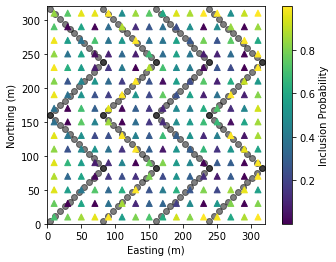

In [30]:
res2 = np.load("res_spectral2.npy")
plt.scatter(das_x, das_y, c='k', alpha=0.5)
cax = plt.scatter(xs, ys, c=res2, marker='^')
plt.xlim(0,320)
plt.ylim(0,320)
plt.colorbar(cax, label="Inclusion Probability")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")

In [110]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, axis=0):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data, axis=axis)
    return y

def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, [low], btype='low')
    return b, a


def butter_low_filter(data, lowcut, fs, order=5, axis=0):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = lfilter(b, a, data, axis=axis)
    return y

In [ ]:
np.sqrt(2)*320 / 2000 * 8000 # = length of diagonal * approx samples to cross diagonal * assumed samples / s = m / s velocity

In [143]:
shot = np.reshape(np.fromfile("Testing/TestData/shot1.dat", dtype=np.float32), (4001,64,64))
t = np.linspace(0, 0.5, 4001)
shotf = butter_low_filter(shot, 50, 8000)
tf = t[::20]
shotf = shotf[::20,:,:]
tf_freq = 1/(tf[1]-tf[0])

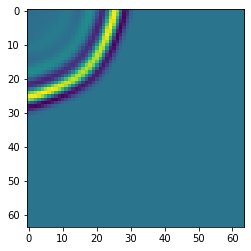

In [144]:
plt.imshow(shotf[49])

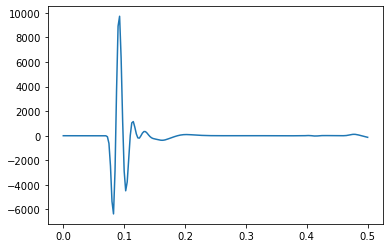

In [145]:
plt.plot(tf, shotf[:, 10, 10])

In [147]:
from scipy.interpolate import RectBivariateSpline as rbs

In [ ]:
shotf_itps = [rbs()]

In [ ]:
exxr = fftintr.ev(das_x,das_y, dx=2)
eyyr = fftintr.ev(das_x,das_y, dy=2)
exyr = (fftintr.ev(das_x,das_y, dx=1,dy=1)+fftintr.ev(das_x,das_y, dy=1,dx=1))/2 
edasr = (np.sin(das_azr)**2*exxr+np.sin(2*das_azr)*exyr+np.cos(das_azr)**2*eyyr)